# Munging, Modeling and Pipelines using H2O Python
## Hank Roark (hank@h2o.ai, @hankroark)
## Presented at H2O World 2015

# Import and initialize h2o

In [1]:
import h2o

In [2]:
h2o.init()

--------------------------  -------------------------------------
H2O cluster uptime:         9 minutes 54 seconds 135 milliseconds
H2O cluster version:        3.6.0.2
H2O cluster name:           H2ODemo
H2O cluster total nodes:    1
H2O cluster total memory:   192.19 GB
H2O cluster total cores:    32
H2O cluster allowed cores:  32
H2O cluster healthy:        True
H2O Connection ip:          127.0.0.1
H2O Connection port:        54321
--------------------------  -------------------------------------

# Define the names of the features
These are both the features in the original data file and some of the features that will be created later on.

In [4]:
# Setup the column names of the training file
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['RemainingUsefulLife']

# And some variables that will be engineered later
operating_modes = 6 # known apriori from dataset description
operating_mode_column_name = ["OperatingMode"]
operating_mode_cummulative_name = ["CountInMode"+str(i) for i in range(0,operating_modes)]

# Import the training and test sets, look at summary statistics

In [5]:
train = h2o.upload_file("train_FD004.txt")
test  = h2o.upload_file("test_FD004.txt")
train.set_names(input_file_column_names);
test.set_names(input_file_column_names);


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


In [178]:
train.describe()

Rows:61,249 Cols:26

Chunk compression summary:


chunk_type    chunk_name                 count    count_percentage    size      size_percentage
------------  -------------------------  -------  ------------------  --------  -----------------
C1            1-Byte Integers            2        3.84615             59.9 KB   1.88852
C1N           1-Byte Integers (w/o NAs)  2        3.84615             59.9 KB   1.88852
C1S           1-Byte Fractions           6        11.5385             179.9 KB  5.6685
C2            2-Byte Integers            4        7.69231             239.5 KB  7.54569
C2S           2-Byte Fractions           32       61.5385             1.9 MB    60.3813
C4S           4-Byte Fractions           6        11.5385             718.3 KB  22.6275


Frame distribution summary:


size    number_of_rows    number_of_chunks_per_column    number_of_chunks
----------------  ------  ----------------  -----------------------------  ------------------
10.10.0.41:54321  3.1 MB  61249             2                              52
mean              3.1 MB  61249             2                              52
min               3.1 MB  61249             2                              52
max               3.1 MB  61249             2                              52
stddev            0  B    0                 0                              0
total             3.1 MB  61249             2                              52

UnitNumber Cycle OpSet1 OpSet2 OpSet3 SensorMeasure1 SensorMeasure2 SensorMeasure3 SensorMeasure4 SensorMeasure5 SensorMeasure6 SensorMeasure7 SensorMeasure8 SensorMeasure9 SensorMeasure10 SensorMeasure11 SensorMeasure12 SensorMeasure13 SensorMeasure14 SensorMeasure15 SensorMeasure16 SensorMeasure17 SensorMeasure18 SensorMeasure19 SensorMeasure20 SensorMeasure21 
 type int int real real int real real real real real real real real real real real real real real real real int int real real real 
 mins 1.0 1.0 0.0 0.0 60.0 445.0 535.48 1242.67 1024.42 3.91 5.67 136.17 1914.72 7984.51 0.93 36.04 128.31 2027.57 7845.78 8.1757 0.02 302.0 1915.0 84.93 10.16 6.0843 
 mean 124.325180819 134.311417329 23.9998233424 0.571346890561 94.0315760257 472.882435468 579.420055511 1417.89660027 1201.91535927 8.03162582246 11.589457134 283.328633121 2228.68603373 8524.67330128 1.09644500318 42.8745292168 266.735665072 2334.42758967 8067.81181211 9.28560359516 0.0232524612647 347.760028735 2228.61328348 97.7513962677 20.8643334585 12.5189954938 
 maxs 249.0 543.0 42.008 0.842 100.0 518.67 644.42 1613.0 1440.77 14.62 21.61 570.81 2388.64 9196.81 1.32 48.36 537.49 2390.49 8261.65 11.0663 0.03 399.0 2388.0 100.0 39.89 23.8852 
 sigma 71.9953498537 89.7833894132 14.7807216523 0.310703444054 14.2519539188 26.4368316429 37.3426467018 106.167597738 119.327590688 3.62287211738 5.44401654316 146.880209523 145.348242887 336.927546543 0.127680528593 3.24349153499 138.479109163 128.197859249 85.670543449 0.750373686479 0.00468470561338 27.8082834535 145.472491191 5.36942363891 9.93639614294 5.96269725095 
 zeros 0 0 162 4776 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 1.0 1.0 42.0049 0.84 100.0 445.0 549.68 1343.43 1112.93 3.91 5.7 137.36 2211.86 8311.32 1.01 41.69 129.78 2387.99 8074.83 9.3335 0.02 330.0 2212.0 100.0 10.62 6.367 
 1 1.0 2.0 20.002 0.7002 100.0 491.19 606.07 1477.61 1237.5 9.35 13.61 332.1 2323.66 8713.6 1.07 43.94 312.59 2387.73 8046.13 9.1913 0.02 361.0 2324.0 100.0 24.37 14.6552 
 2 1.0 3.0 42.0038 0.8409 100.0 445.0 548.95 1343.12 1117.05 3.91 5.69 138.18 2211.92 8306.69 1.01 41.66 129.62 2387.97 8066.62 9.4007 0.02 329.0 2212.0 100.0 10.48 6.4213 
 3 1.0 4.0 42.0 0.84 100.0 445.0 548.7 1341.24 1118.03 3.91 5.7 137.98 2211.88 8312.35 1.02 41.68 129.8 2388.02 8076.05 9.3369 0.02 328.0 2212.0 100.0 10.54 6.4176 
 4 1.0 5.0 25.0063 0.6207 60.0 462.54 536.1 1255.23 1033.59 7.05 9.0 174.82 1915.22 7994.94 0.93 36.48 164.11 2028.08 7865.8 10.8366 0.02 305.0 1915.0 84.93 14.03 8.6754 
 5 1.0 6.0 34.9996 0.84 100.0 449.44 554.77 1352.87 1117.01 5.48 7.97 193.82 2222.77 8340.0 1.02 41.44 181.9 2387.87 8054.1 9.3346 0.02 330.0 2223.0 100.0 14.91 8.9057 
 6 1.0 7.0 0.0019 0.0001 100.0 518.67 641.83 1583.47 1393.89 14.62 21.58 552.45 2387.92 9050.5 1.3 46.94 520.48 2387.89 8127.92 8.396 0.03 391.0 2388.0 100.0 38.93 23.4578 
 7 1.0 8.0 41.9981 0.84 100.0 445.0 549.05 1344.16 1110.77 3.91 5.69 137.13 2211.92 8307.28 1.01 41.6 129.65 2387.97 8075.99 9.3679 0.02 329.0 2212.0 100.0 10.55 6.2787 
 8 1.0 9.0 42.0016 0.84 100.0 445.0 549.55 1342.85 1101.67 3.91 5.7 138.02 2211.9 8307.81 1.02 41.44 129.65 2388.0 8071.13 9.3384 0.02 328.0 2212.0 100.0 10.63 6.3055 
 9 1.0 10.0 25.0019 0.6217 60.0 462.54 536.35 1251.91 1041.37 7.05 9.01 174.7 1915.23 8005.83 0.94 36.24 164.08 2028.13 7869.41 10.9141 0.02 305.0 1915.0 84.93 14.34 8.6119

# Target (feature) engineering
Create the target field, remaining useful life, by determining the total cycles for each of the training units and then calculating the number of cycles remaining.

In [6]:
def add_remaining_useful_life(h2o_frame):
    # Get the total number of cycles for each unit
    grouped_by_unit = h2o_frame.group_by(by=["UnitNumber"])
    max_cycle = grouped_by_unit.max(col="Cycle").frame
    
    # Merge the max cycle back into the original frame
    result_frame = h2o_frame.merge(max_cycle)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_Cycle"] - \
                            result_frame["Cycle"]
    result_frame["RemainingUsefulLife"] = remaining_useful_life
    
    # drop the un-needed column
    result_frame = result_frame.drop("max_Cycle")
    return result_frame

train_with_predictor = add_remaining_useful_life(train)

# Exploratory data analysis

In [7]:
# For some EDA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Sample a few units and pull from H2O memory space to the Python memory space

In [8]:
sample_units = train_with_predictor["UnitNumber"] < 3
train_pd = train_with_predictor[sample_units].as_data_frame(use_pandas=True)

#### The sensor data does not show any trends over time, making it difficult to make predictions about the future from the observed data

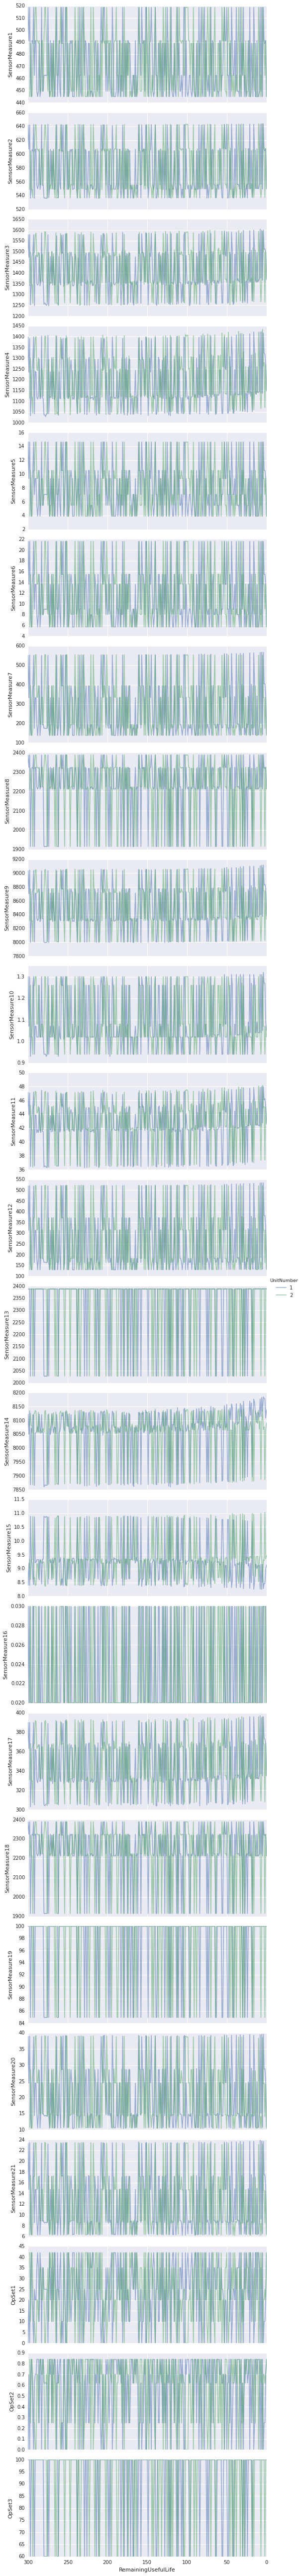

In [9]:
g = sns.PairGrid(data=train_pd,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

#### The sensor measurements happen in 6 clusters; this open investigation coincides with the operating modes

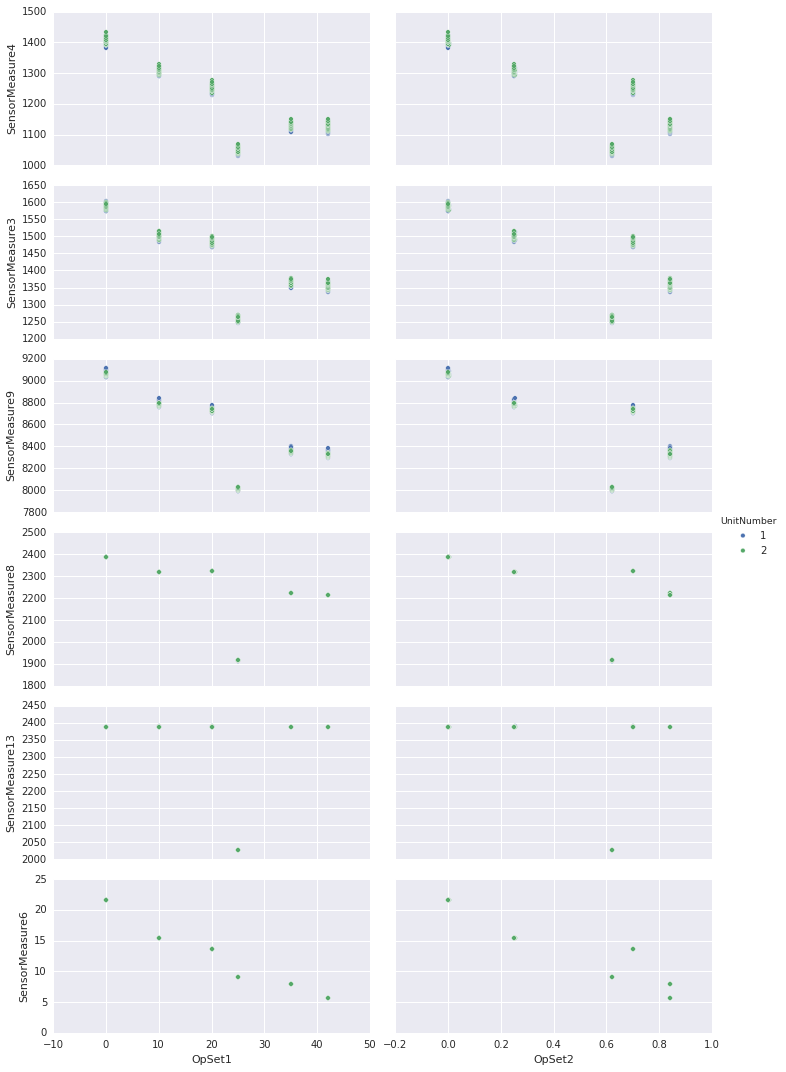

In [12]:
g = sns.pairplot(data=train_pd,
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", 
                         "SensorMeasure9", "SensorMeasure8", 
                         "SensorMeasure13", "SensorMeasure6"],
                 hue="UnitNumber", aspect=2)

# Model based data enrichment
Use machine learning to label each observation, corresponding the the six operating modes of the units.

In [13]:
from h2o.estimators.kmeans import H2OKMeansEstimator

In [14]:
operating_mode_estimator = H2OKMeansEstimator(k=operating_modes)
operating_mode_estimator.train(x=operational_settings_columns_names,
                              training_frame=train_with_predictor)


kmeans Model Build Progress: [##################################################] 100%


In [15]:
def append_operating_mode(h2o_frame, estimator):
    operating_mode_labels = estimator.predict(h2o_frame)
    operating_mode_labels.set_names(operating_mode_column_name);
    operating_mode_labels = operating_mode_labels.asfactor()
    h2o_frame_augmented = h2o_frame.cbind(operating_mode_labels)
    return h2o_frame_augmented

train_augmented = append_operating_mode(train_with_predictor,operating_mode_estimator)
test_augmented = append_operating_mode(test,operating_mode_estimator)

### Use visualization to review that clustering happened as expected

In [16]:
train_pd = train_augmented[sample_units].as_data_frame(use_pandas=True)

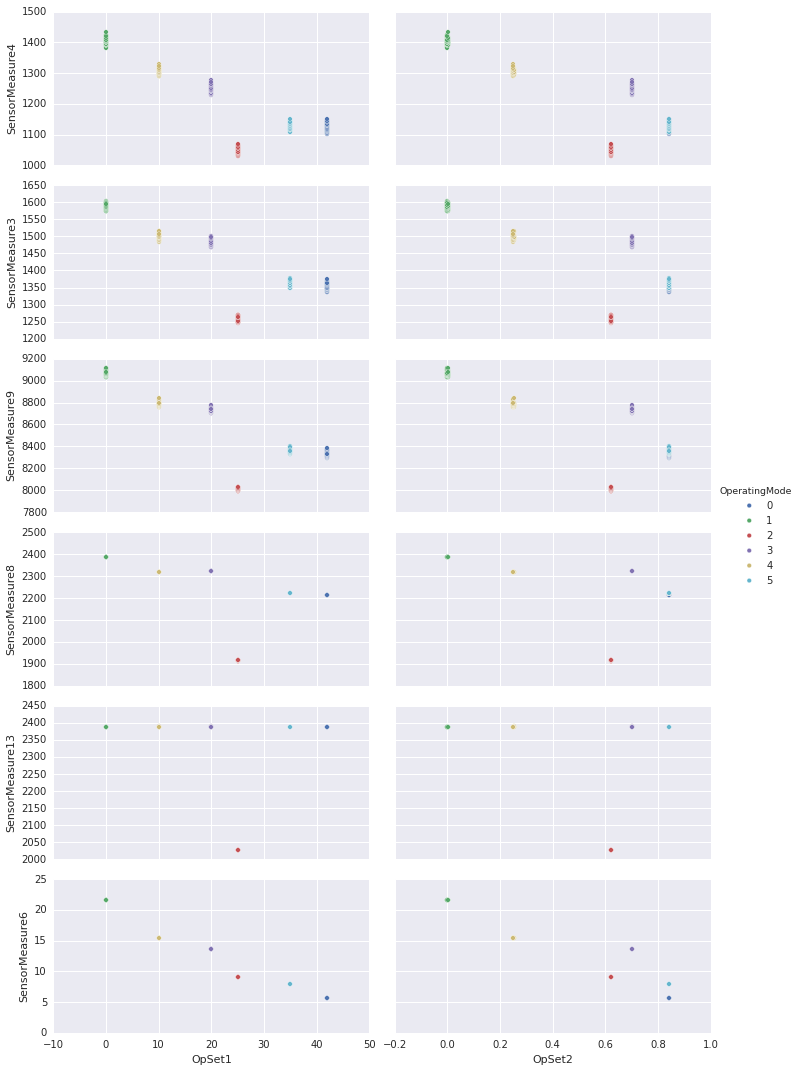

In [17]:
g = sns.pairplot(data=train_pd,
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", "SensorMeasure9", "SensorMeasure8", "SensorMeasure13", "SensorMeasure6"],
                 hue=operating_mode_column_name[0], aspect=2)

# Feature engineering
Standardize the sensor measurements based on the mean and standard deviation within each operating mode, from the training data.  

Ignore the sensors with constant measurements within an operating mode.

Apply to both training and test data.

In [18]:
def standardize_by_operating_mode(train, test):
    t = train.group_by(operating_mode_column_name).\
        mean(sensor_measure_columns_names).\
        sd(sensor_measure_columns_names).frame

    s = train.merge(t)
    r = test.merge(t)
    standardize_measures_columns_names = []
    for sensor_measure_column_name in sensor_measure_columns_names:
        include_this_measure = True
        # if any of the operating modes shows 0 or NaN standard deviation, 
        # do not standardize that sensor measure,b
        # nor use it in the model building
        for i in range(0,operating_modes):
            stdev = t[t["OperatingMode"] == str(i),"sdev_"+sensor_measure_column_name][0,0]
            if stdev == 0.0: 
                include_this_measure = False
                break
        if include_this_measure:
            new_column_name = "stdized_"+sensor_measure_column_name
            standardize_measures_columns_names.append(new_column_name)
            s[new_column_name] = ((s[sensor_measure_column_name]-
                                   s["mean_"+sensor_measure_column_name])/
                                   s["sdev_"+sensor_measure_column_name])
            r[new_column_name] = ((r[sensor_measure_column_name]-
                                   r["mean_"+sensor_measure_column_name])/
                                   r["sdev_"+sensor_measure_column_name])
    return (s,r,standardize_measures_columns_names)

train_stdized, test_stdized, standardized_measures_columns_names = \
    standardize_by_operating_mode(train_augmented, test_augmented)

### Use visualization to understand the impact

In [19]:
sample_units2 = train_with_predictor["UnitNumber"] < 6
train_pd = train_stdized[sample_units2].as_data_frame(use_pandas=True)

## Trends over time!!

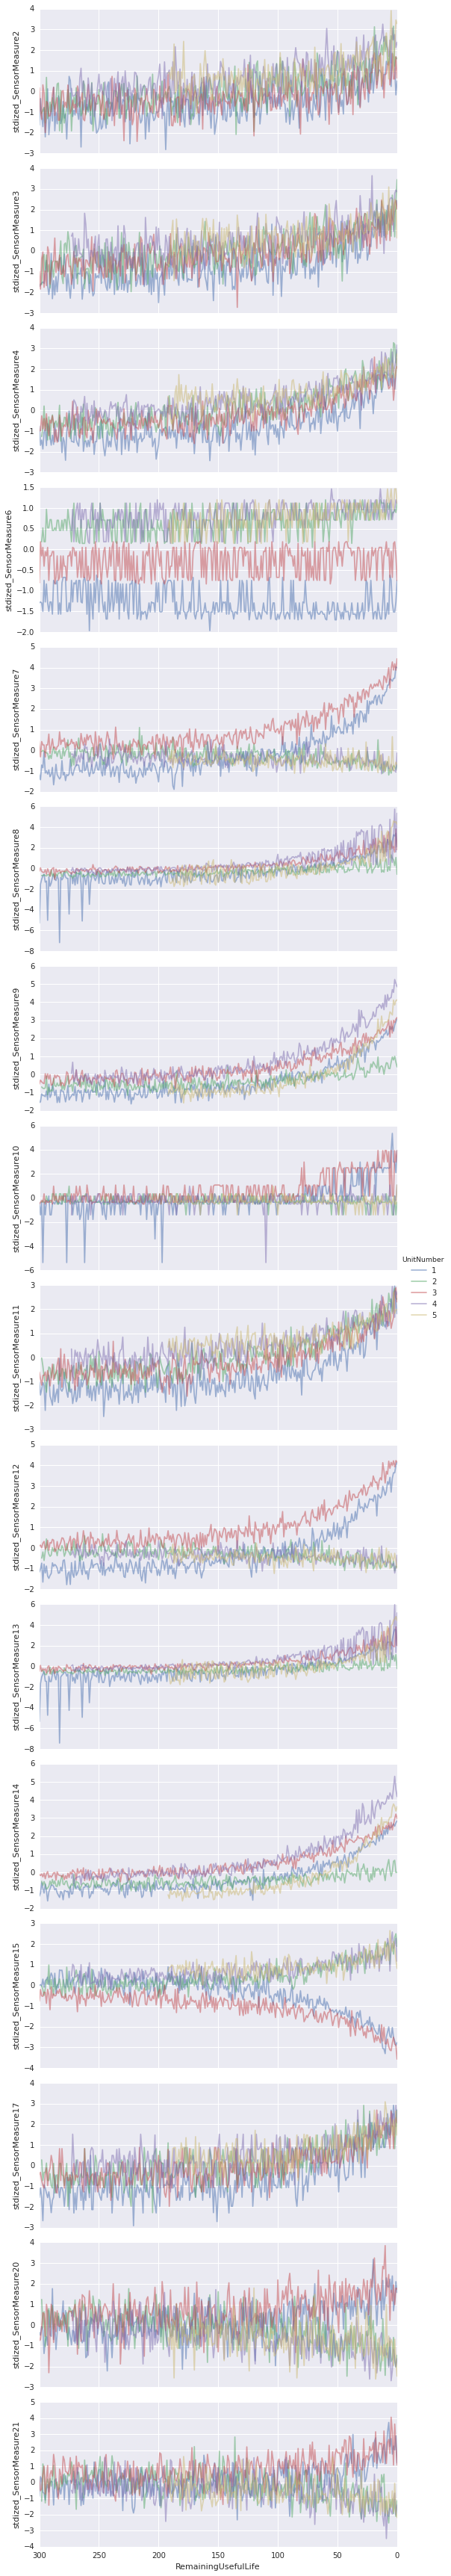

In [20]:
g = sns.PairGrid(data=train_pd,
                 x_vars=dependent_var,
                 y_vars=standardized_measures_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

In [21]:
def add_cummulative_in_mode(frame):
    g = frame[['UnitNumber','OperatingMode','Cycle']].as_data_frame(use_pandas=True) # Get the smallest data needed
    for k in range(0,operating_modes):
        g['One'+str(k)] = 1*(g['OperatingMode']==k)
    for k in range(0,6):
        g['CountInMode'+str(k)] = g.groupby(['UnitNumber'])['One'+str(k)].cumsum()
        g.drop('One'+str(k), axis=1, inplace=True)
    
    g.drop('OperatingMode', axis=1, inplace=True)  # Not needed for the join, no reason to send back to H2O
    h = h2o.H2OFrame.from_python(g.to_dict(orient='list'))
    i = frame.merge(h)
    i.columns; # Force the merge to happen, not lazily
    return i

In [22]:
train_final = add_cummulative_in_mode(train_stdized)
test_final = add_cummulative_in_mode(test_stdized)


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


These next two steps are not needed.  I have a practice of saving data ready for modeling so that I can start modeling  without recreating the data preparation steps.

In [24]:
export_dir = "/home/ec2-user/python-examples/cmapdata/"
h2o.export_file(train_final,export_dir+"train_FD004_processed.csv", force=True)
h2o.export_file(test_final,export_dir+"test_FD004_processed.csv", force=True)


Export File Progress: [##################################################] 100%

Export File Progress: [##################################################] 100%


In [25]:
train_final = h2o.upload_file("train_FD004_processed.csv")
test_final = h2o.upload_file("test_FD004_processed.csv")


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


# Modeling the data

Build up the final independent variable vector and review the list.  It is 22 dimensional real as an input.

In [26]:
independent_vars = operating_mode_cummulative_name + standardized_measures_columns_names

In [27]:
independent_vars

['CountInMode0',
 'CountInMode1',
 'CountInMode2',
 'CountInMode3',
 'CountInMode4',
 'CountInMode5',
 'stdized_SensorMeasure2',
 'stdized_SensorMeasure3',
 'stdized_SensorMeasure4',
 'stdized_SensorMeasure6',
 'stdized_SensorMeasure7',
 'stdized_SensorMeasure8',
 'stdized_SensorMeasure9',
 'stdized_SensorMeasure10',
 'stdized_SensorMeasure11',
 'stdized_SensorMeasure12',
 'stdized_SensorMeasure13',
 'stdized_SensorMeasure14',
 'stdized_SensorMeasure15',
 'stdized_SensorMeasure17',
 'stdized_SensorMeasure20',
 'stdized_SensorMeasure21']

## Cross validation strategy
Use approximately 90% of the units for model building and cross validate with the other 10% of the units.  Use units as the information for the fold, not individual observations of the units.

In [28]:
fold_column_name = "FoldColumn"
train_final[fold_column_name] = train_final["UnitNumber"] % 10

## Build a H2O GBM Estimator, train the estimator, and review model results

In [29]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [30]:
gbm_regressor = H2OGradientBoostingEstimator(distribution="gaussian", 
                                             score_each_iteration=True,
                                             stopping_metric="MSE", 
                                             stopping_tolerance=0.001,
                                             stopping_rounds=5)
gbm_regressor.train(x=independent_vars, y=dependent_var, 
                    training_frame=train_final,
                    fold_column=fold_column_name)


gbm Model Build Progress: [##################################################] 100%


In [31]:
gbm_regressor

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1446915311057_17

Model Summary:


number_of_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    40                 17211                  5            5            5             27            32            31.625



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2163.66503487
R^2: 0.731586024356
Mean Residual Deviance: 2163.66503487

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2593.6000911
R^2: 0.678250329666
Mean Residual Deviance: 2593.6000911

Scoring History:


timestamp            duration    number_of_trees    training_MSE    training_deviance
---  -------------------  ----------  -----------------  --------------  -------------------
     2015-11-07 17:08:15  29.900 sec  1.0                7051.27074015   7051.27074015
     2015-11-07 17:08:15  29.973 sec  2.0                6223.94886964   6223.94886964
     2015-11-07 17:08:16  30.028 sec  3.0                5545.77949665   5545.77949665
     2015-11-07 17:08:16  30.085 sec  4.0                4982.5535961    4982.5535961
     2015-11-07 17:08:16  30.135 sec  5.0                4525.92458033   4525.92458033
---  ---                  ---         ---                ---             ---
     2015-11-07 17:08:17  31.617 sec  36.0               2190.50861032   2190.50861032
     2015-11-07 17:08:17  31.678 sec  37.0               2185.04779156   2185.04779156
     2015-11-07 17:08:17  31.722 sec  38.0               2179.80679078   2179.80679078
     2015-11-07 17:08:17  31.759 sec  39.0               2169.34053891   2169.34053891
     2015-11-07 17:08:17  31.802 sec  40.0               2163.66503487   2163.66503487


Variable Importances:


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  -----------------
stdized_SensorMeasure11  817994240.0            1.0                  0.43028336135
CountInMode0             202449856.0            0.247495454247       0.106493175972
stdized_SensorMeasure4   172273600.0            0.210604905971       0.0906197868581
CountInMode5             163339248.0            0.199682638352       0.0859201168335
CountInMode2             117894848.0            0.144126745929       0.0620153406989
---                      ---                    ---                  ---
stdized_SensorMeasure2   5354265.5              0.00654560293725     0.00281646403391
stdized_SensorMeasure7   2409670.5              0.00294582820045     0.00126754086005
stdized_SensorMeasure10  521770.59375           0.000637865853126    0.000274463063374
stdized_SensorMeasure20  489988.0625            0.000599011629348    0.000257744737364
stdized_SensorMeasure21  112600.96875           0.000137654965333    5.92306411902e-05

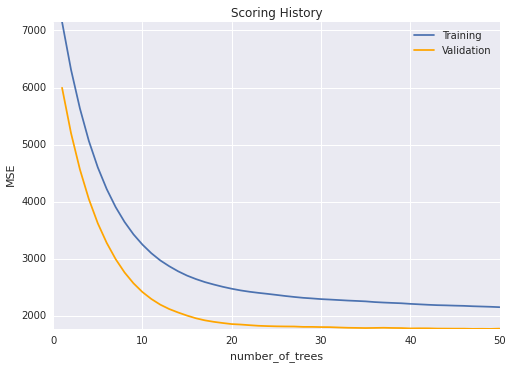

In [32]:
gbm_regressor.get_xval_models()[0].plot()

## Use H2O's grid search for doing hyperparameter searches

In [33]:
from h2o.grid.grid_search import H2OGridSearch

ntrees_opt = [1000]
max_depth_opt = [2, 5, 7]
learn_rate_opt = [0.01]
min_rows_opt = [5, 10, 15]
hyper_parameters = {"ntrees": ntrees_opt,
                    "max_depth":max_depth_opt, 
                    "learn_rate":learn_rate_opt,
                    "min_rows": min_rows_opt}

gs = H2OGridSearch(gbm_regressor, hyper_params=hyper_parameters)

gs.train(x=independent_vars, y=dependent_var, 
         training_frame=train_final, 
         fold_column=fold_column_name)


gbm Grid Build Progress: [##################################################] 100%


In [35]:
gs.sort_by('mse', increasing=True)


Grid Search Results for H2OGradientBoostingEstimator:


Model Id                                               Hyperparameters: [learn_rate, ntrees, min_rows, max_depth]    mse
-----------------------------------------------------  ------------------------------------------------------------  -------
Grid_GBM_py_257_model_python_1446915311057_18_model_6  [0.01, 255, 5.0, 7]                                           1954.06
Grid_GBM_py_257_model_python_1446915311057_18_model_7  [0.01, 255, 10.0, 7]                                          1959.59
Grid_GBM_py_257_model_python_1446915311057_18_model_8  [0.01, 256, 15.0, 7]                                          1964.94
Grid_GBM_py_257_model_python_1446915311057_18_model_4  [0.01, 282, 10.0, 5]                                          2264.25
Grid_GBM_py_257_model_python_1446915311057_18_model_3  [0.01, 281, 5.0, 5]                                           2264.6
Grid_GBM_py_257_model_python_1446915311057_18_model_5  [0.01, 281, 15.0, 5]                                          2265.36
Grid_GBM_py_257_model_python_1446915311057_18_model_2  [0.01, 381, 15.0, 2]                                          2650.48
Grid_GBM_py_257_model_python_1446915311057_18_model_1  [0.01, 381, 10.0, 2]                                          2650.48
Grid_GBM_py_257_model_python_1446915311057_18_model_0  [0.01, 381, 5.0, 2]                                           2650.48

In [61]:
# Turn off h2o progress bars
h2o.__PROGRESS_BAR__=False
h2o.no_progress()

# Demonstartion of H2O integration with SciKit framework
This model pipeline was built as a demonstration and is not used in the final data product.

In [156]:
class PreviouslyDefinedFold():
  def __init__(self, fold_assignments):
    self.fold_assignments=fold_assignments
    self.fold_column_name=fold_assignments.col_names[0]
    self.fold_list = self.fold_assignments.group_by(0).frame.as_data_frame()[0][1:]
    self.masks = None
    
  def __iter__(self):
    for test_mask in self._test_masks():
      yield 1 - test_mask, test_mask

  def __len__(self):
    return len(self.fold_list)

  def _test_masks(self):
    if self.masks is None: 
        self.masks = [self.fold_assignments[self.fold_column_name] == int(i) for i in self.fold_list]
    return self.masks

In [187]:
from h2o.transforms.decomposition import H2OPCA
from h2o.estimators.glm import H2OGeneralizedLinearEstimator 
from h2o.model.regression import h2o_mean_squared_error
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("pca", H2OPCA(k=2)),
                     ("glm", H2OGeneralizedLinearEstimator(family="gaussian"))])

params = {"pca__k":                range(2,len(independent_vars)),
          "glm__alpha":            [0, 0.5, 1],
          "glm__lambda":           [1e-2, 3e-3, 1e-3, 3e-4, 1e-4]}

custom_cv = PreviouslyDefinedFold(train_final[fold_column_name])

random_search = RandomizedSearchCV(pipeline, params,
                                   n_iter=5,
                                   scoring=make_scorer(h2o_mean_squared_error),
                                   cv=custom_cv,
                                   random_state=42,
                                   n_jobs=1,refit=True)

random_search.fit(train_final[independent_vars], train_final[dependent_var])


No model trained yet
No model trained yet


RandomizedSearchCV(cv=<__main__.PreviouslyDefinedFold instance at 0x7f76c373b290>,
          error_score='raise',
          estimator=Pipeline(steps=[('pca', ), ('glm', )]), fit_params={},
          iid=True, n_iter=5, n_jobs=1,
          param_distributions={'glm__lambda': [0.01, 0.003, 0.001, 0.0003, 0.0001], 'pca__k': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'glm__alpha': [0, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          scoring=make_scorer(h2o_mean_squared_error), verbose=0)

In [188]:
print random_search.best_estimator_

Model Details
H2OPCA :  Principal Component Analysis
Model Key:  PCA_model_python_1446915311057_2093

Importance of components:


pc1       pc2         pc3         pc4
----------------------  --------  ----------  ----------  ----------
Standard deviation      67.6091   4.57835     3.97709     3.82738
Proportion of Variance  0.980673  0.00449709  0.00339346  0.00314281
Cumulative Proportion   0.980673  0.98517     0.988563    0.991706



ModelMetricsPCA: pca
** Reported on train data. **

MSE: NaN
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1446915311057_2095

GLM Model: summary



family    link      regularization                             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -----------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.01 )  5                             4                              1                       py_7247



ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 4999.87470738
R^2: 0.379739365242
Mean Residual Deviance: 4999.87470738
Null degrees of freedom: 61248
Residual degrees of freedom: 61244
Null deviance: 493723620.026
Residual deviance: 306237325.952
AIC: 695497.163393

Scoring History:


timestamp            duration    iteration    log_likelihood    objective
--  -------------------  ----------  -----------  ----------------  -----------
    2015-11-08 21:06:26  0.000 sec   0            2.46862e+08       4030.46

Pipeline(steps=[('pca', ), ('glm', )])


## Prediction on the test data
Using the best model from the grid search (using MSE)

There is previous version of the work that uses the final scoring to pick the best model, this was kept simple on purpose.

In [196]:
grid_search_results = gs.sort_by('mse', increasing=True)
best_model_id = grid_search_results['Model Id'][0]
best_model = h2o.get_model(best_model_id)

### Use the main model and each cross validated model to build an ensemble of predictions

In [221]:
def sensor_preds(frame):
    frame["predict"] = ((frame["predict"] < 0.).ifelse(0., frame["predict"]))[0]
    return frame

models_for_pred = [best_model]+best_model.xvals
preds = [ sensor_preds(model.predict(test_final)) for model in models_for_pred ]
index = test_final[["UnitNumber","Cycle"]]
for i,pred in enumerate(preds):
    if i == 0:
        predictions = index.cbind(preds[i])
    else:
        predictions = predictions.cbind(preds[i])

predictions_df = predictions.as_data_frame(use_pandas=True)

# Prediction post processing
Because these are linear dynamic systems, with the prior belief that after each operation the unit's remaining useful life decreases by one, a Kalman filter is used to post process and ensemble the data.

In [ ]:
# state is represented as [RUL, -1]
n_dim_state=2
n_dim_obs=len(preds)
a_transition_matrix = np.array([[1,1],[0,1]])
r_observation_covariance = np.diag( [ model.mse() for model in models_for_pred ] )
h_observation_matrices = np.array([[1,0] for _ in models_for_pred])

In [245]:
import pykalman as pyk

final_ensembled_preds = {}
pred_cols = [ name for name in predictions_df.columns if "predict" in name]
for unit in predictions_df.UnitNumber.unique():
    preds_for_unit = predictions_df[ predictions_df.UnitNumber == unit ]
    observations = preds_for_unit.as_matrix(pred_cols)
    initial_state_mean = np.array( [np.mean(observations[0]),-1] )
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,\
                          initial_state_mean=initial_state_mean,\
                          observation_covariance=r_observation_covariance,\
                          observation_matrices=h_observation_matrices,\
                          n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
    mean,_ = kf.filter(observations)
    final_ensembled_preds[unit] = mean

In [246]:
final_preds = { k:final_ensembled_preds[k][-1][0] for k in final_ensembled_preds.keys() }

In [247]:
final_preds_df = pd.DataFrame.from_dict(final_preds,orient='index')
final_preds_df.columns = ['predicted']

## Do final scoring on the test data

In [248]:
actual_RUL = pd.read_csv("RUL_FD004.txt",header=None,names=["actual"])
actual_RUL.index = actual_RUL.index+1
actual_preds = actual_RUL.join(final_preds_df)

def score(x):
    diff = x.predicted-x.actual
    result = np.expm1(diff/-13.) if diff < 0. else np.expm1(diff/10.)
    return result

actual_preds["score"] = actual_preds.apply(score, axis=1)
sum(actual_preds.score)/len(actual_preds)

1390.4973851879122

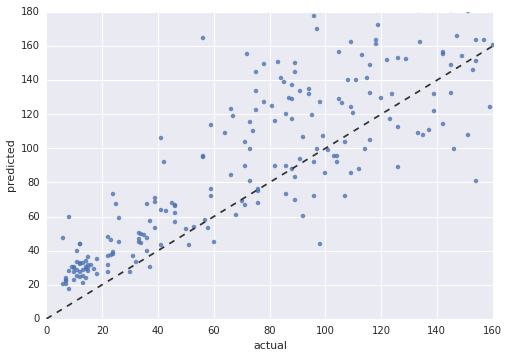

In [250]:
g = sns.regplot("actual", "predicted", data=actual_preds, fit_reg=False)
g.set(xlim=(0, 160), ylim=(0, 180));
g.axes.plot((0, 160), (0, 160), c=".2", ls="--");